In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

# Load data

In [4]:
ad = sc.read_h5ad('AML3.decipher.post-analyzed.h5ad')
#blast_bas = ad.varm["trajectory_basis_disease"]
#normal_bas = ad.varm["trajectory_basis_healthy"]


In [5]:
rna = ad

In [6]:
rna.obs["trajectory_projection"] = rna.obs["decipher_time"]

In [7]:
blast_p = rna.uns["decipher_gene_patterns"]["origin=AML3"]
blast_p.index = [i for i in range(blast_p.shape[0])]
blast_p["pseudotime"] = blast_p.index

normal_p = rna.uns["decipher_gene_patterns"]["origin=Healthy"]
normal_p.index = [i for i in range(normal_p.shape[0])]
normal_p["pseudotime"] = normal_p.index


In [8]:
for i in range(rna.shape[0]):
    if "BM" in rna.obs_names[i]:
        print(i)
        break

12000


In [9]:
p_rna = rna[0:12000,:]
bm_rna = rna[12000:,:]

In [10]:
p_rna_df = p_rna.obs
bm_rna_df = bm_rna.obs

In [11]:
normal_p.index=range(len(normal_p))

# Local maxima detection via derivatives

In [12]:
from numpy import diff
def local_max_fcn(y, dy, ddy):
    #return the indices of identified local maxes
    
    local_max = []
    #check to see if starting point is a local max
    if max(y)==y[0]:
        local_max.append(0)
    if max(y)==y[len(y)-1]:
        local_max.append(len(y)-1)
    
    #find the midrange of the data, we get rid of maxima lower than this
    percentile = np.mean([max(y),min(y)])#

    #set sign flag to initial point
    flag = np.sign(dy[0])
    
    if np.sign(dy[0])==-1 and y[0]>percentile:
        local_max.append(0)
        
    for i in range(len(dy)):
        #look for changes in sign
        if np.sign(dy[i]) != flag:
            #if the slope goes from positive to negative, then it's a local max
            if np.sign(dy[i])==-1 and flag==1:
                if y[i]>percentile:
                    local_max.append(i)
            #change the flag (we ignore local min)
            flag = np.sign(dy[i])

    return local_max

## Get disrupted TFs

In [16]:
aml1 = pd.read_csv("AML3.disruption_scores.csv")

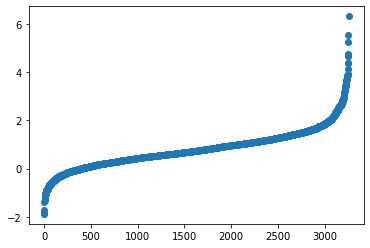

In [17]:
plt.scatter([i for i in range(aml1.shape[0])],np.log(np.sort(aml1["gene_std"])))

In [18]:
#filter some genes by std
aml1_filtered = aml1[np.log(aml1["gene_std"])>0]
aml1_filtered.index = aml1_filtered["gene"]

In [19]:
#read in TFs list
tfs=pd.read_csv("Human_TF_MotifList_v_1.01.txt",sep='\t')

tfs_in=[]
for i in tfs["HGNC symbol"]:
    if i in aml1_filtered.index and i in normal_p.columns:
        tfs_in.append(i)
tfs_in=np.unique(tfs_in)

In [373]:
#generate most disrupted TF list
most_disrupted = list(aml1_filtered.loc[tfs_in].sort_values(by='combined',ascending=False)[0:50]["gene"])

### Lists of TFs to use in each patient

In [13]:
#AML3
all_genes = [
    'NFE2',"CEBPE","CD34","MEIS1",'MYBL2', #hematopoiesis
    'MAFF', 'CEBPE', 'BACH1', 'ARID3A','HOXA10', 'HOXA3', 'HOXA9', 'HOXB2', 'HOXB3', 'HOXB4', #inflammation
    'MYC', 'UBP1', #cell cycle
    'ZNF22', 'ZNF217', 'JDP2', 'MNT', 'RXRA', 'HHEX', 'HLX', 'ZNF281', 'HMGA1', 'RBPJ', 'LYL1',"DNMT1" #regulation
    
]
tf_colors = [
    '#00FF00','#00FF00','#00FF00','#00FF00','#00FF00',
    '#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000',
    '#0000FF','#0000FF','#0000FF',
    '#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4','#7A42E4'
]

In [327]:
#AML2
all_genes = [
    'PRDM1',#immune
    'GATA1', 'MYBL2',  'CEBPE', 'NFIL3', 'KLF1', 'CD34', 'MEIS1','IRX3', 'HES4', 'ZNF711', 'ZNF521', #hematopoiesis+development
    'MAFB', 'IRF8', 'NR4A3', 'ATF3', 'NR4A1', 'MAFF', 'HOXA3', 'HOXA9', 'HOXB2', 'HOXB3', 'HOXB4', #inflammation
    'E2F1', 'CREB5', 'HIVEP1' #cell cycle
]
tf_colors = [
    '#FF00FF',
     '#00FF00', '#00FF00', '#00FF00', '#00FF00', '#00FF00', '#00FF00', '#00FF00','#00FF00','#00FF00','#00FF00','#00FF00',
    '#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000',
    '#0000FF','#0000FF','#0000FF'
]

In [350]:
#AML1
all_genes = [
 "CD34", "GATA1","PBX3","MAFB","ELF4","KLF1","CEBPA","CEBPE","ZBTB43", #development  
 "NFIL3","MYBL2","BHLHE40", #cell cycle
 "PRDM1","BCL6", #immune
 "CREB5","AHR","SMAD3", #signaling
 "FOSL1","FOSL2", #FOS/JUN family
 "HOXA3","HOXA9","HOXA10","HOXB2","HOXB3","HOXB4","MEIS1","HLX" #homeobox
 
]
tf_colors = [
    '#00FF00','#00FF00','#00FF00','#00FF00','#00FF00','#00FF00','#00FF00','#00FF00','#00FF00',
    '#0000FF','#0000FF','#0000FF',
    '#FF00FF','#FF00FF',
    '#00FFFF','#00FFFF','#00FFFF',
    '#FFD700','#FFD700',
    '#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000','#FF0000'
    
]

In [20]:
#make colors into a dictionary
color_dict = {}
for i in range(len(all_genes)):
    color_dict[all_genes[i]]=tf_colors[i]

# Plotting

In [21]:
#get data for where TFs are peaking
blast_maxes = {}
normal_maxes = {}
for tf in all_genes:
    smoothed_n = scipy.ndimage.gaussian_filter1d(normal_p[tf], 3)
    smoothed_b = scipy.ndimage.gaussian_filter1d(blast_p[tf], 3)
    dx = 1
    dy_n = diff(smoothed_n)/dx
    ddy_n = diff(dy_n)/dx

    dy_b = diff(smoothed_b)/dx
    ddy_b = diff(dy_b)/dx

    blast_maxes[tf] = local_max_fcn(smoothed_b, dy_b, ddy_b)
    normal_maxes[tf] = local_max_fcn(smoothed_n, dy_n, ddy_n)
    
#get data for all TFs for kde plot
blast_all = {}
normal_all = {}
for tf in tfs_in:
    smoothed_n = scipy.ndimage.gaussian_filter1d(normal_p[tf], 3)
    smoothed_b = scipy.ndimage.gaussian_filter1d(blast_p[tf], 3)
    dx = 1
    dy_n = diff(smoothed_n)/dx
    ddy_n = diff(dy_n)/dx

    dy_b = diff(smoothed_b)/dx
    ddy_b = diff(dy_b)/dx

    blast_all[tf] = local_max_fcn(smoothed_b, dy_b, ddy_b)
    normal_all[tf] = local_max_fcn(smoothed_n, dy_n, ddy_n)

In [22]:
#if we are interested in exporting max peak times
blast_max_times = pd.DataFrame()
for i in blast_maxes.keys():
    if len(blast_maxes[i])>0:
        peak_height = []
        for j in blast_maxes[i]:
            peak_height.append(blast_p[i][j])
        blast_max_times[i] = [blast_maxes[i][np.argmax(peak_height)]]

blast_max_times = blast_max_times.T
blast_max_times.columns = ["max peak time"]

#blast_max_times.to_csv("AML1_tf_network_peak_times.csv")
    

In [23]:
cell_type_colors = {'immature': 'tab:brown',
                    'blast0': 'tab:blue',
                    'blast1':'tab:orange',
                    'blast2':'tab:green',
                    'blast3':'tab:red',
                    'mep':'lightgrey'
}
#{"mep":"#ffccf9","blast3":"#e36969","blast2":"#f8edaa","blast1":"#FFA15C","blast0":"#44D492","immature":"#88F7E2","ery":"#b77d55","lympho":"#c497ef"}

In [24]:
font = {'family': 'serif',
        'weight' : 'bold',
        'size'   : 10}

plt.rc('font', **font)

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


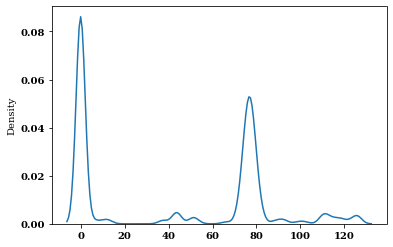

In [25]:
hist_n = []
for key in normal_all.keys():
    for i in normal_all[key]:
        hist_n.append(i)
        
data = hist_n
density=sns.kdeplot(data,bw=.05)
density_lim_normal = density.get_ylim()[1]
# Get the current axis object
ax = plt.gca()

# Retrieve the data from the kdeplot
line = ax.lines[0]
x_data_n = line.get_xdata()
y_data_n = line.get_ydata()

/Users/joyfan/miniconda3/envs/labenv/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.05 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


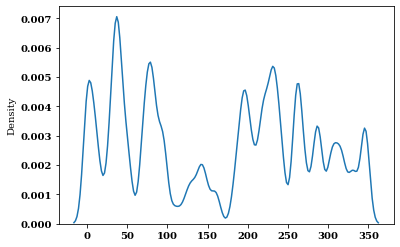

In [26]:
hist_b = []
for key in blast_all.keys():
    for i in blast_all[key]:
        hist_b.append(i)
        
data = hist_b
density=sns.kdeplot(data,bw=.05)
density_lim_blast = density.get_ylim()[1]
# Get the current axis object
ax = plt.gca()

# Retrieve the data from the kdeplot
line = ax.lines[0]
x_data = line.get_xdata()
y_data = line.get_ydata()

In [27]:
#sort genes based on earliest peak time
earliest_blast = pd.DataFrame()
for i in blast_maxes.keys():
    earliest_blast[i]=[np.argmax(blast_p[i])]#[min(blast_maxes[i])]

earliest_blast = earliest_blast.T.sort_values(by=0,ascending=False)

In [28]:
earliest_normal = pd.DataFrame()
for i in normal_maxes.keys():
    earliest_normal[i]=[np.argmax(normal_p[i])]

earliest_normal = earliest_normal.T.sort_values(by=0,ascending=False)

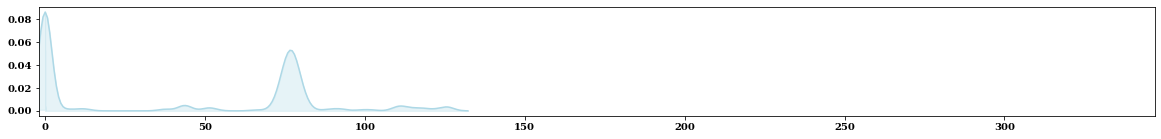

In [30]:
fig= plt.figure(figsize=(20, 2))
aa = fig.add_subplot(1,1,1)
aa.set_xlim([-2, blast_p.shape[0]])
aa.plot(x_data_n,y_data_n,c='lightblue')
aa.fill_betweenx(y_data_n,x_data_n, where=(y_data_n > 0), color='lightblue', alpha=0.3)  

#plot gene and celltype indicator bars underneath
#colors = [cell_type_colors[i] for i in bm_filtered_types["smoothed_types"]]
plt.savefig("AML3_normal_tf_kde.pdf",format='pdf')

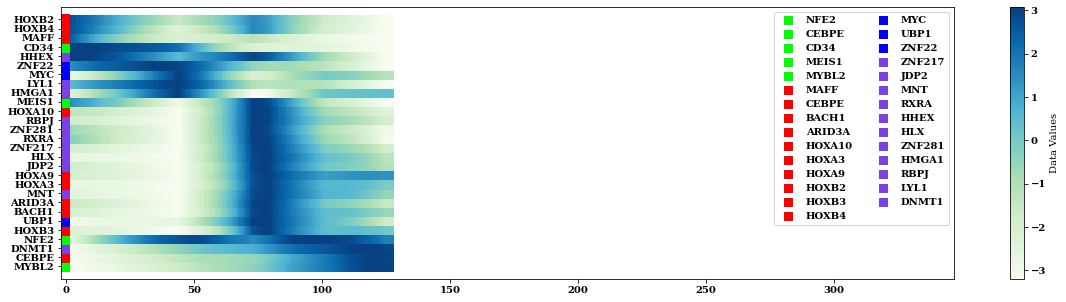

In [31]:
fig= plt.figure(figsize=(20, 5))
aa = fig.add_subplot(1,1,1)
aa.set_xlim([-2, blast_p.shape[0]])
dat=scipy.stats.zscore(normal_p[normal_maxes.keys()][earliest_normal.index]).T
for i in range(dat.shape[0]):
    aa.scatter([j for j in range(dat.shape[1])],[i for j in range(dat.shape[1])]
               ,c=dat[i,:],cmap="GnBu",marker="s",s=80)

    aa.scatter([-1],[i],c=color_dict[earliest_normal.index[i]],marker="s",s=82)
plt.yticks([i for i in range(dat.shape[0])],labels=list(earliest_normal.index))

#make a legend
# Create custom legend handles with your own labels
legend_handles = []
for color, label in zip( tf_colors, all_genes):
    legend_handles.append(Line2D([], [], marker='s', color='w', markerfacecolor=color, markersize=10, label=label))

min_value = np.min(dat)
max_value = np.max(dat)

# Create a colormap (you can choose from various predefined colormaps or create your own)
cmap = plt.cm.GnBu  # Example colormap (you can change it)

# Create a normalization instance which maps data values to the range [0, 1]
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Create a ScalarMappable object that can be used to create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a colorbar
colorbar = plt.colorbar(sm)

# Set the colorbar label
colorbar.set_label('Data Values')

    # Add legend with custom handles and labels
plt.legend(handles=legend_handles,ncol=2)
plt.savefig("AML3_normal_tf_cascade.pdf",format='pdf')

In [32]:
rna.obs["MPO"]=rna.to_df()["MPO"]
rna.obs["LYZ"]=rna.to_df()["LYZ"]

#map cell type labels by nearest neighbor projection
inds = []
for i in range(p_rna.shape[0]):
    curr = p_rna.obs["cell_type_merged"][i]
    if curr!="mep" and curr!="lympho" and curr!="ery":
        inds.append(i)
p_rna_filtered = p_rna[inds,:]

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=50, radius=0.2)

neigh.fit(p_rna_filtered.obsm["decipher_v_corrected"])

A = neigh.kneighbors_graph(p_rna_filtered.obsm["decipher_v_corrected"])
adj = A.toarray()

smoothed_types = []
smoothed_npm_mut = []
for i in range(adj.shape[0]):
    smoothed_types.append(scipy.stats.mode(p_rna_filtered.obs["cell_type_merged"][np.nonzero(adj[i])[0]])[0][0])
    smoothed_npm_mut.append(np.mean(p_rna_filtered.obs["NPM1 mutation vs wild type"][np.nonzero(adj[i])[0]]))
p_rna_filtered.obs["smoothed_types"] = smoothed_types
p_rna_filtered.obs["smoothed_npm"] = smoothed_npm_mut

#scale aml projections
max_orig = max(p_rna_filtered.obs["trajectory_projection"])

#omax of rna projection is 4.45, max of original is 190
#100/190 = 2.34/4.45 so we truncate at 2.34

filtered_types = p_rna_filtered.obs

#now to scale 2.34 to 100 we can multiply everything by 100/2.34
filtered_types["scaled_projection"] = filtered_types["trajectory_projection"]*(blast_p.shape[0])/max_orig

Trying to set attribute `.obs` of view, copying.


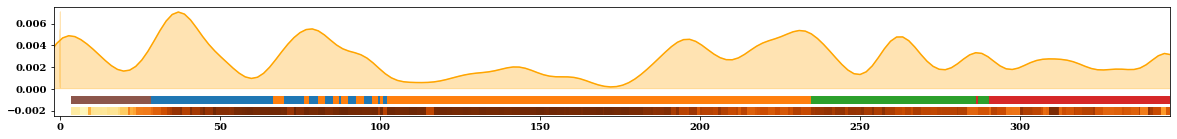

In [33]:
fig= plt.figure(figsize=(20, 2))
aa = fig.add_subplot(1,1,1)
aa.set_xlim([-2, blast_p.shape[0]])
aa.plot(x_data,y_data,c='orange')
aa.fill_betweenx(y_data,x_data, where=(y_data_n > 0), color='orange', alpha=0.3)    
#plot gene and celltype indicator bars underneath
colors = [cell_type_colors[i] for i in filtered_types["smoothed_types"]]
aa.scatter(filtered_types["scaled_projection"],[-.001 for i in range(filtered_types.shape[0])],
            c=colors,marker="s",label=colors,s=50)
aa.scatter(filtered_types["scaled_projection"],[-.002 for i in range(filtered_types.shape[0])],
           c=filtered_types["smoothed_npm"],marker="s",s=50,cmap='YlOrBr')
plt.savefig("AML3_blast_tf_kde.pdf",format='pdf')

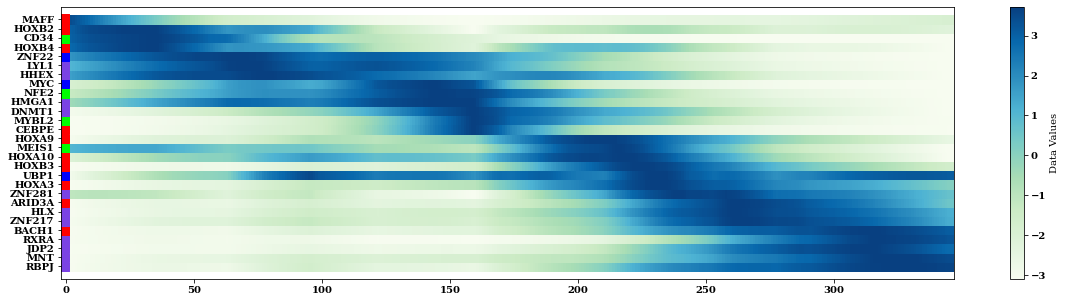

In [34]:
fig= plt.figure(figsize=(20, 5))
aa = fig.add_subplot(1,1,1)
aa.set_xlim([-2, blast_p.shape[0]])
dat=scipy.stats.zscore(blast_p[blast_maxes.keys()][earliest_blast.index]).T
for i in range(dat.shape[0]):
    aa.scatter([j for j in range(dat.shape[1])],[i for j in range(dat.shape[1])]
               ,c=dat[i,:],cmap="GnBu",marker="s",s=80)
    aa.scatter([-1],[i],c=color_dict[earliest_blast.index[i]],marker="s",s=82)
    plt.yticks([i for i in range(dat.shape[0])],labels=list(earliest_blast.index))

min_value = np.min(dat)
max_value = np.max(dat)

# Create a colormap (you can choose from various predefined colormaps or create your own)
cmap = plt.cm.GnBu  # Example colormap (you can change it)

# Create a normalization instance which maps data values to the range [0, 1]
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)

# Create a ScalarMappable object that can be used to create a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a colorbar
colorbar = plt.colorbar(sm)

# Set the colorbar label
colorbar.set_label('Data Values')

plt.savefig("AML3_blast_tf_cascade.pdf",format='pdf')

# Identify TFs peaking before vs after NPM1 mutation

Text(0, 0.5, 'smoothed npm1 mutation')

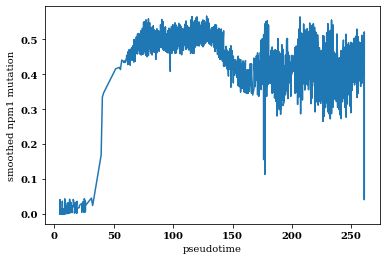

In [176]:
plt.plot(filtered_types.sort_values(by='scaled_projection')['scaled_projection'],
         filtered_types.sort_values(by='scaled_projection')['smoothed_npm'])
plt.xlabel("pseudotime")
plt.ylabel("smoothed npm1 mutation")

Text(0, 0.5, 'smoothed npm1 mutation')

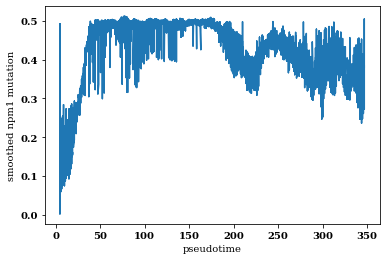

In [144]:
plt.plot(filtered_types.sort_values(by='scaled_projection')['scaled_projection'],
         filtered_types.sort_values(by='scaled_projection')['smoothed_npm'])
plt.xlabel("pseudotime")
plt.ylabel("smoothed npm1 mutation")

In [356]:
aml1_latest_blast = earliest_blast[earliest_blast[0]>50]
aml1_latest_blast.index

Index(['MAFB', 'PRDM1', 'HIF1A', 'ARID5B', 'NR4A1', 'NR4A3', 'FOXO3', 'SMAD3',
       'ZNF267', 'BACH1', 'BHLHE40', 'AHR', 'GZF1', 'ZBTB43', 'MXD1', 'FOSL2',
       'BCL6', 'ZBTB7A', 'NFIL3', 'ELF4', 'IRF8', 'MYBL2', 'RUNX2', 'TP53',
       'CEBPE', 'HOXA3', 'HOXA10', 'HOXA9', 'CEBPA', 'MYC', 'MYB', 'KLF13',
       'HOXB3', 'MAFK', 'IKZF1', 'HLX', 'MEIS1', 'ZZZ3', 'NFE2', 'HOXB4',
       'PBX3'],
      dtype='object')

In [357]:
#AML1
aml1_earliest_blast = earliest_blast[earliest_blast[0]<50].index
aml1_earliest_blast

Index(['HOXB2', 'ZNF394', 'RELB', 'IRF9', 'KLF2', 'ATF3', 'KLF1', 'NFKB2',
       'RELA', 'GATA1', 'FOSL1', 'CREB5', 'CD34', 'ZNF274', 'ZNF331', 'MAFF'],
      dtype='object')

In [333]:
aml2_latest_blast = earliest_blast[earliest_blast[0]>=50]
aml2_latest_blast.index

Index(['IRF8', 'MAFB', 'BCL6', 'CEBPB', 'HES4', 'JUNB', 'PRDM1', 'HIF1A',
       'NFKB2', 'NFAT5', 'KLF7', 'FOSL2', 'MYBL2', 'E2F1', 'CEBPE', 'MXD1',
       'IRX3', 'CREB5', 'BHLHE40', 'RFX2', 'NFIL3', 'EGR1', 'DDIT3', 'HIVEP1',
       'KLF2', 'ATF3', 'JUN', 'HOXB3', 'ZNF117', 'AHR', 'HOXA3', 'ETS1',
       'TCF3', 'ZNF711', 'NR4A1'],
      dtype='object')

In [334]:
#AML2
aml2_earliest_blast = earliest_blast[earliest_blast[0]<50].index
aml2_earliest_blast

Index(['NR4A2', 'ZNF521', 'TFDP2', 'ZNF331', 'NR4A3', 'MEIS1', 'HOXA9',
       'HOXB6', 'HOXB4', 'HOXB2', 'HOXB5', 'MAFF', 'CD34', 'KLF1', 'ERG',
       'GFI1B', 'MYC', 'GATA1'],
      dtype='object')

In [380]:
aml3_latest_blast = earliest_blast[earliest_blast[0]>=50]
aml3_latest_blast.index

Index(['SMAD3', 'HES4', 'POU2F2', 'RBPJ', 'MNT', 'JDP2', 'BACH1', 'BHLHE40',
       'RXRA', 'KLF4', 'SPI1', 'MBD2', 'KLF6', 'ZBTB7A', 'NFIL3', 'ZNF787',
       'ZBTB18', 'ZNF217', 'ARID3A', 'HLX', 'ELF4', 'MEF2D', 'KLF13', 'NR3C1',
       'ZNF281', 'HOXA3', 'ERF', 'UBP1', 'HOXB3', 'HOXA10', 'MEIS1', 'RUNX1',
       'HOXA9', 'GFI1', 'CREB3L2', 'BCL11A', 'ZNF90', 'MYBL2', 'CEBPE',
       'DNMT1', 'GTF3A', 'NFE2', 'HMGA1', 'KLF1', 'MYC', 'MYB', 'ETV6', 'HHEX',
       'HOXA7', 'LYL1', 'ZNF22'],
      dtype='object')

In [381]:
aml3_earliest_blast = earliest_blast[earliest_blast[0]<50].index
aml3_earliest_blast

Index(['ZNF32', 'GATA2', 'HOXB4', 'CD34', 'HOXB2', 'ATF3', 'MAFF'], dtype='object')

In [177]:
all_motifs = ["HOXB2","FOSL1","CREB5","GATA1","KLF1","CD34","ZNF521","NR4A3","MEIS1","HOXA9","HOXB4","HOXB2","MAFF","GATA1","KLF1","CD34","HOXB4","CD34","HOXB2","MAFF"]

In [66]:
earliest_blast[earliest_blast[0]<50]

,0
HOXB2,33
FOSL1,0
CREB5,0
GATA1,0
KLF1,0
CD34,0


In [145]:
earliest_blast[earliest_blast[0]<50]

,0
HOXB4,36
CD34,36
HOXB2,30
MAFF,0


In [386]:
motifs50 = np.unique(list(aml1_earliest_blast)+list(aml2_earliest_blast)+list(aml3_earliest_blast))